# Прогнозирование вероятности оттока пользователей для фитнес-центров.

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

План:
 - сделать прогноз вероятности оттока (на уровне следующего месяца) для каждого клиента;
 - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
 - проанализировать основные признаки, наиболее сильно влияющие на отток;
 - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
   1. выделить целевые группы клиентов;
   2. предложить меры по снижению оттока;
   3. определить другие особенности взаимодействия с клиентами.


Набор данных включает следующие поля:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Загрузка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# кластеризация
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
#для удобства отобразим все колонки таблицы, округлим числовые значения до сотых
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# прочитаем из csv-файла данные о клиентах, распечатаем первые 5 строк
clients = pd.read_csv('/datasets/gym_churn.csv')
clients.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
# приводим название столбцов к нижнему регистру
clients.columns = [x.lower() for x in clients.columns.values]
clients.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
# сэкономим память, откорректировав тип данных
columns_to_int16 = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age', 'lifetime', 'churn', 'month_to_end_contract']
for row in columns_to_int16:
    clients[row] = clients[row].astype('int16')

In [6]:
# проверка на пропуски
clients.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [7]:
# проверка на явные дубликаты
clients.duplicated().sum()

0

### Вывод
На первом этапе загрузили данные о клиентах в переменную. Оптимизировали данные для анализа: привели название столбцов к единому виду, произвели необходимые изменения типов данных, проверили датафрейм на дубли и отсутствующие значения.

## Исследовательский анализ данных

In [8]:
# посмотрим на датафрейм
display(clients.shape)
clients.info()

(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int16  
 1   near_location                      4000 non-null   int16  
 2   partner                            4000 non-null   int16  
 3   promo_friends                      4000 non-null   int16  
 4   phone                              4000 non-null   int16  
 5   contract_period                    4000 non-null   int16  
 6   group_visits                       4000 non-null   int16  
 7   age                                4000 non-null   int16  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int16  
 10  lifetime                           4000 non-null   int16  
 11  avg_class_frequency_total          4000 non-null   float

In [9]:
clients.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Как видим, одни признаки являются числовыми, другие - категориальными. Для категориального признака достаточно посчитать среднее, для числового - посмотреть на распределение.

In [10]:
# создадим списки столбцов с различными типами признаков
numeric_c = []
categ_c = []
for col in clients.columns: 
    if clients[col].nunique() > 2:
        numeric_c.append(col)
    else:
        categ_c.append(col)

In [11]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 
clients[categ_c].groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,group_visits
churn,,,,,,
0,0.51,0.87,0.53,0.35,0.90,0.46
1,0.51,0.77,0.36,0.18,0.90,0.27


По этим данным можно сделать выводы:
- мужчин и женщин примерно одинаковое количество в обеих группах;
- большинство посетителей клуба живет рядом;
- больше половины оставшихся имеет скидки на абонемент (сотрудники компании-партнера);
- лишь 18% от ушедших клиентов пришли в клуб по приглашению друга;
- контактный номер телефона указан почти у всех;
- 46% оставшихся клиентов посещает групповые занятия.

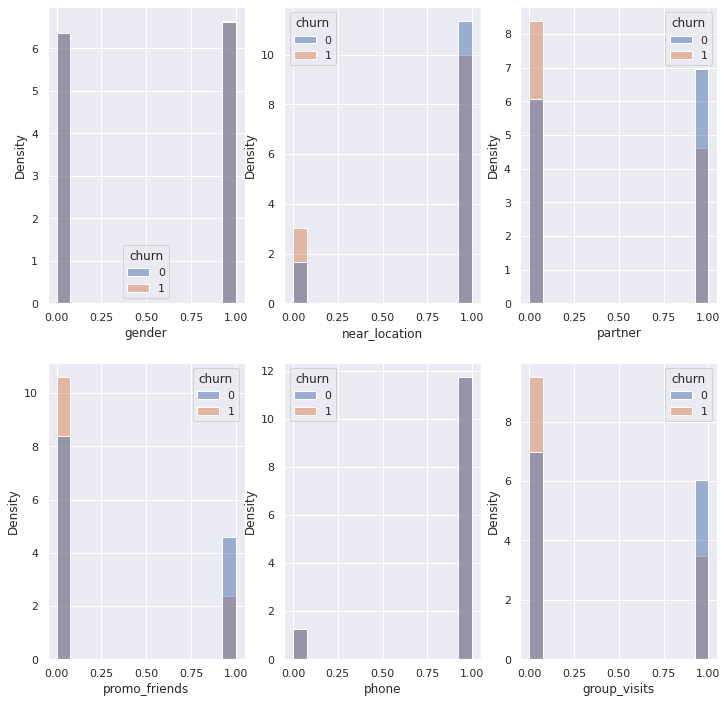

In [13]:
#построим histplot-графики для категориальных признаков
f, axes = plt.subplots(2, 3, figsize = (12, 12))
for ax, col in enumerate(categ_c):
    sns.histplot(x = clients[col], hue='churn', data=clients, 
                 stat='density', common_norm=False, 
                 ax = plt.subplot(2, 3, ax+1))

Пол никак не влияет на отток клиентов. 

Для клиентов, которые остались, характерно следующее:
- они с большей вероятностью живут недалеко от фитнес-клуба;
- с большей вероятностью участвуют в партнерской программе или пришли по рекомендации друзей;
- чаще указывают номер телефона;
- с большей частотой посещают групповые занятия.

In [14]:
# средние для числовых признаков
clients[numeric_c].describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,4.68,29.18,146.94,4.32,3.72,1.88,1.77
std,4.55,3.26,96.36,4.19,3.75,0.97,1.05
min,1.00,18.00,0.15,1.00,0.00,0.00,0.00
25%,1.00,27.00,68.87,1.00,1.00,1.18,0.96
50%,1.00,29.00,136.22,1.00,3.00,1.83,1.72
75%,6.00,31.00,210.95,6.00,5.00,2.54,2.51
max,12.00,41.00,552.59,12.00,31.00,6.02,6.15


- Больше половины берет абонемент всего на месяц.
- Средний возраст - 29 лет (41 год - максимальный).
- Среднее время с момента первого обращения в фитнес-центр - 3,5 месяца. 
- Средняя частота посещений в неделю - меньше двух.

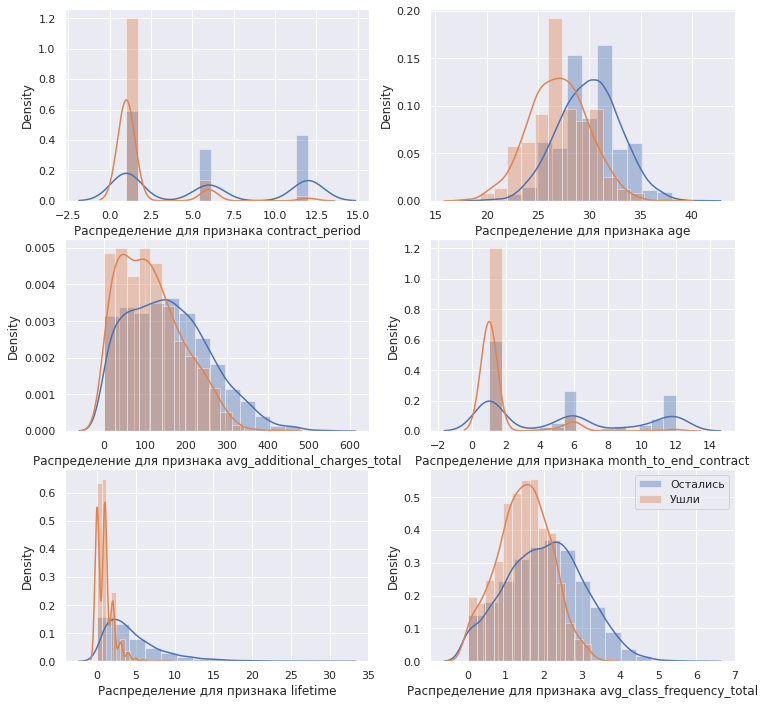

In [15]:
# построим гистограммы и распределения для числовых признаков
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, numeric_c):
    sns.distplot(clients.query('churn==0')[col], bins=15,ax=ax, label ='Остались')
    sns.distplot(clients.query('churn==1')[col], bins=15,ax=ax, label ='Ушли')
    ax.set(xlabel='Распределение для признака ' + col)
plt.legend(loc='upper right')
plt.show()

На графиках видно, что для ушедших клиентов характерно следующее:

- меньшее количество посещений клуба в среднем и еще более заметная разница для текущего месяца;
- меньшее количество трат на дополнительные услуги фитнес-центра;
- в среднем меньший срок абонемента. Абсолютное большинство ушедших клиентов брали абонемент на месяц, этому же соответствует количество месяцев до окончания контракта;
- средний возраст ушедшего клиента меньше, чем средний возраст оставшегося;
- клиенты, которые пользуются клубом меньше 5 месяцев, больше всего подвержены к оттоку.

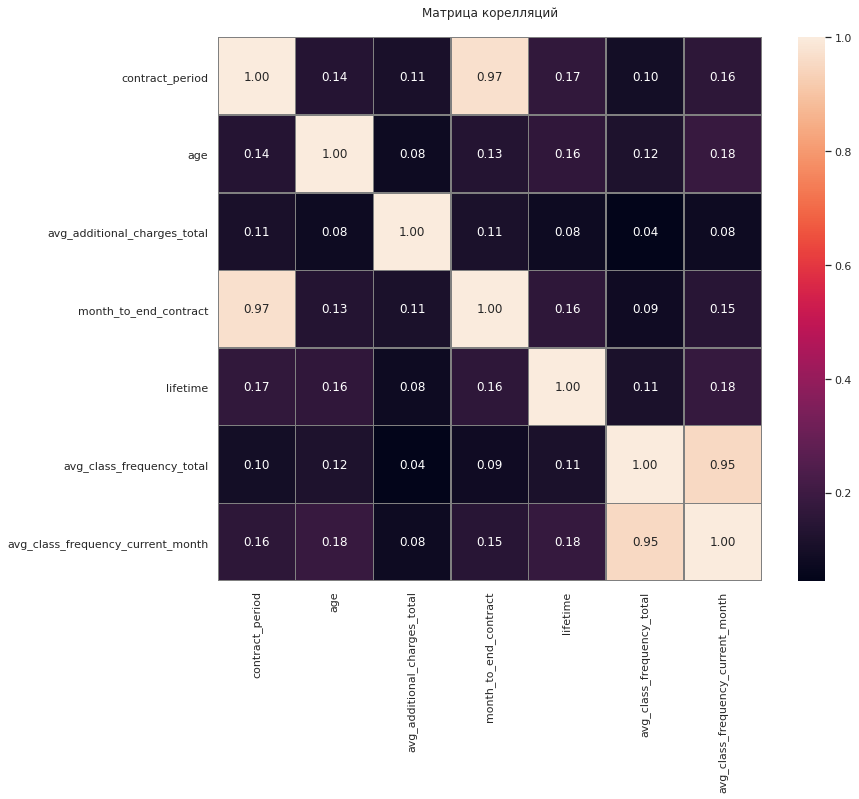

In [16]:
# построим матрицу корреляций
cm = clients[numeric_c].corr()
plt.figure(figsize=(13, 10))
plt.title('Матрица корелляций' + '\n')
sns.heatmap(cm, annot=True, square=True, fmt='.2f', linewidths=.5, linecolor='gray') 
plt.show()

Есть мультиколлинеарные признаки - `contract_period` и `month_to_end_contract`, `avg_class_frequency_current_month` и `avg_class_frequency_total`. 

Есть признаки с нулевой корреляцией с целевой переменной, это `phone` и `gender`, они вообще никак не влияют на отток. 

Наиболее сильно влияют на отток: время с момента первого обращения в фитнес-центр (`lifetime`), количество псещений в последний месяц (`avg_class_frequency_total`), возраст (`age`), длительность текущего действующего абонемента.
А также наличие скидок по партнерской программе или приглашения от друга.


### Вывод
- Возрастной признак сильно коррелирует с оттоком: в отток попадают более молодые клиенты.
- Количество посещений в последний месяц также сильно влияет на отток.
- Время действия абонемента и время с момента первого обращения в клуб сказываются на оттоке клиентов.
 

Чаще всего нас покидают более молодые клиенты, которые берут пробный абонемент на месяц, редко посещают клуб, не посещают групповые занятия.

## Построение моделей прогнозирования оттока клиентов

In [17]:
# следует удалить признаки, которые сильно коррелируют между собой
clients=clients.drop(columns=['avg_class_frequency_total','month_to_end_contract'])

In [18]:
# разобъем столбцы на обучающую и валидационную выборки
X = clients.drop('churn', axis=1) 
y = clients['churn']

In [19]:
# разделим выборку на обучающую и валидационную в соотношении 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

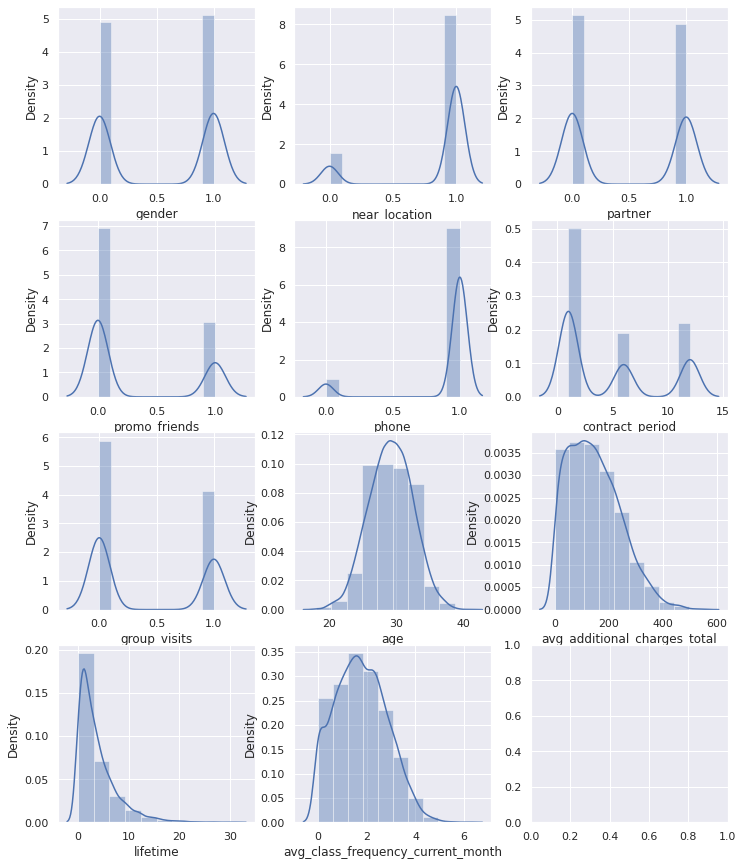

In [20]:
# посмотрим на распределение
f, axes = plt.subplots(4, 3, figsize=(12, 15))
for ax, col in zip(axes.flat, X_train.columns):
    sns.distplot(clients[col], bins=10,ax=ax)
plt.show()

In [21]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

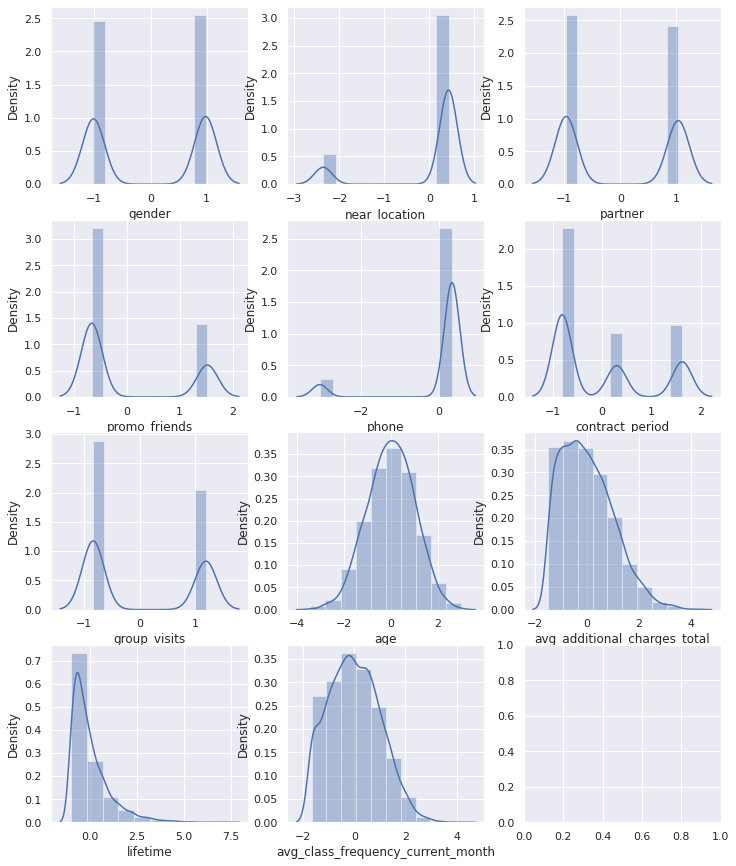

In [22]:
clients_st = pd.DataFrame(data = X_train_st, columns = X_train.columns)
f, axes = plt.subplots(4, 3, figsize=(12, 15))
for ax, col in zip(axes.flat, clients_st.columns):
    sns.distplot(clients_st[col], bins=10,ax=ax)
plt.show()

In [23]:
#логистическая регрессия без стандартизации
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [24]:
#логистическая регрессия со стандартизацией
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities =  lr_model.predict_proba(X_test_st)[:,1]

In [25]:
# случайный лес
rf_model = RandomForestClassifier (n_estimators=100, random_state=0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [26]:
# напишем функцию для вывода всех метрик
def print_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} F1:{:.2f} ROC_AUC:{:.2f}'.format(
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred),
            roc_auc_score(y_true, y_proba)
        ))

In [27]:
# выведем метрики на экран
print_metrics(y_test, predictions, probabilities , title='Метрики для модели логистической регрессии без Ст:')
print_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии со Ст:')
print_metrics(y_test, rf_predictions, rf_probabilities , title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии без Ст:
Accuracy:0.90 Precision:0.81 Recall:0.83 F1:0.82 ROC_AUC:0.96
Метрики для модели логистической регрессии со Ст:
Accuracy:0.92 Precision:0.85 Recall:0.84 F1:0.84 ROC_AUC:0.97
Метрики для модели случайного леса:
Accuracy:0.91 Precision:0.85 Recall:0.77 F1:0.81 ROC_AUC:0.96


Так как accuracy работает не всегда, а только при условии баланса классов — когда объектов каждого класса примерно поровну, 50% : 50%, этот показатель можно не учитывать.

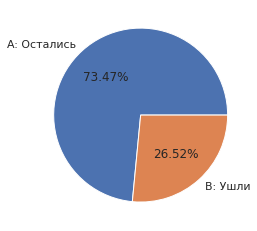

In [28]:
share = clients.groupby('churn').count().reset_index()
plt.pie(share.age, labels=['A: Остались', 'B: Ушли'], autopct='%0.2f%%')
plt.show()

### Вывод

Все модели показали себя хорошо. Но лучший результат в нашем случае показала модель логистической регрессии со стандартизацией.

In [29]:
# попробуем catboost
cat_model = CatBoostClassifier(random_state=0)
cat_model.fit(X_train_st, y_train)
cat_predictions = model.predict(X_test_st) 
cat_probabilities = model.predict_proba(X_test_st)[:,1]

Learning rate set to 0.016929
0:	learn: 0.6729285	total: 48.5ms	remaining: 48.4s
1:	learn: 0.6536258	total: 50.3ms	remaining: 25.1s
2:	learn: 0.6334491	total: 51.5ms	remaining: 17.1s
3:	learn: 0.6130580	total: 52.7ms	remaining: 13.1s
4:	learn: 0.5933791	total: 53.9ms	remaining: 10.7s
5:	learn: 0.5763159	total: 55.1ms	remaining: 9.12s
6:	learn: 0.5593939	total: 56.3ms	remaining: 7.98s
7:	learn: 0.5431642	total: 57.5ms	remaining: 7.13s
8:	learn: 0.5278458	total: 58.6ms	remaining: 6.45s
9:	learn: 0.5187133	total: 59.3ms	remaining: 5.87s
10:	learn: 0.5056821	total: 60.5ms	remaining: 5.44s
11:	learn: 0.4918889	total: 61.6ms	remaining: 5.07s
12:	learn: 0.4798137	total: 63ms	remaining: 4.78s
13:	learn: 0.4689803	total: 64.3ms	remaining: 4.53s
14:	learn: 0.4587526	total: 66.2ms	remaining: 4.35s
15:	learn: 0.4483512	total: 67.4ms	remaining: 4.14s
16:	learn: 0.4386512	total: 68.7ms	remaining: 3.97s
17:	learn: 0.4286658	total: 69.9ms	remaining: 3.81s
18:	learn: 0.4193711	total: 71.2ms	remaining: 

In [30]:
print_metrics(y_test, cat_predictions, cat_probabilities , title='Метрики для модели CatBoost:')

Метрики для модели CatBoost:
Accuracy:0.27 Precision:0.27 Recall:1.00 F1:0.42 ROC_AUC:0.86


Слабо, возможно нужен подбор параметров для данной модели

In [31]:
# оценим важность признаков
lr_df = pd.DataFrame(data={'feature' : X_train.columns, 'coef' : lr_model.coef_[0]})
lr_df.sort_values(by='coef', ascending=True)

,feature,coef
9,lifetime,-3.65
5,contract_period,-1.41
10,avg_class_frequency_current_month,-1.29
7,age,-1.17
8,avg_additional_charges_total,-0.57
6,group_visits,-0.38
3,promo_friends,-0.15
4,phone,-0.08
1,near_location,-0.06
2,partner,-0.06


Минимальное значение коэффициента у признака `lifetime`. То есть вероятность оттока ниже у клиентов, у которых с момента первого обращения в фитнес-центр прошло много времени.

## Кластеризация клиентов

In [32]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

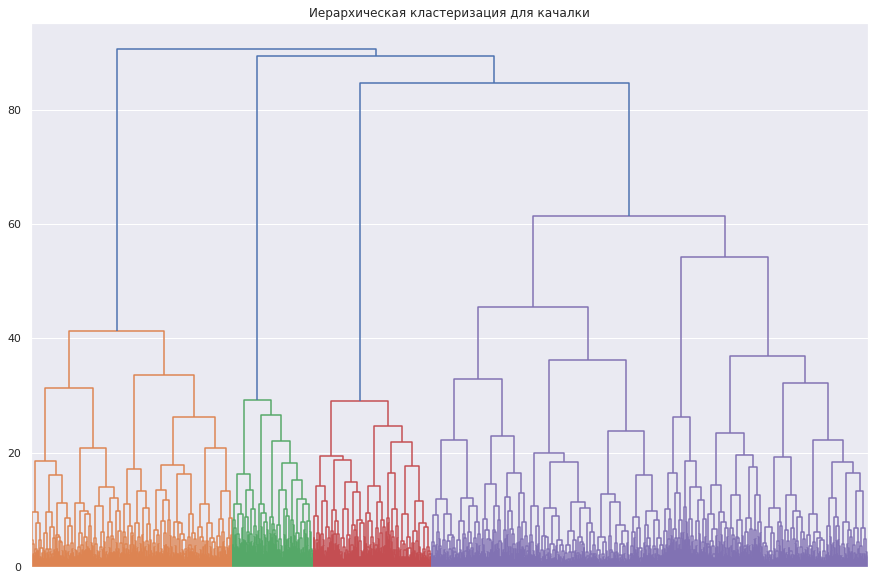

In [33]:
# график кластеризации
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Иерархическая кластеризация для качалки')
plt.show()

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. Однако фиолетовая область слишком большая, поэтому выделим 5 кластеров для дальнейшей работы.

In [34]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [35]:
clients['cluster'] = labels
clients.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.23,3,0.00,0,4
1,0,1,0,0,1,12,1,31,113.20,7,1.91,0,3
2,0,1,1,0,1,1,0,28,129.45,2,1.74,0,2
3,0,1,1,1,1,12,1,33,62.67,2,3.36,0,0
4,1,1,1,1,1,1,0,26,198.36,3,1.12,0,0


In [36]:
# выводим статистику по средним значениям наших признаков по кластеру
clients.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


In [37]:
# количество клиентов в каждом кластере
clients['cluster'].value_counts()

2    1064
3    1007
0     985
1     558
4     386
Name: cluster, dtype: int64

Исходя из данных таблицы можно сделать выводы:

- кластер 3 и 0 - клиенты, для которых отток характерен с наименьшей вероятностью;
- кластеры 2 - наибольшая вероятность оттока 

Больше всего клиентов представлено в 0, 2 и 3 кластерах. В 4 кластер попало меньше всего клиентов - это люди без указанного номера телефона.

Признаки лучших кластеров по показателю оттока: 
- по половому признаку распределены поровну, 
- живут рядом, 
- более чем в половине случаев посещают групповые занятия, 
- их возраст около 30 лет, 
- их абонемент действует примерно шесть месяцев, 
- ходят в зал два раза в неделю,
- клиенты в первый раз пришли в клуб более четырех месяцев назад, 
- в среднем тратят на дополнительные услуги больше остальных.

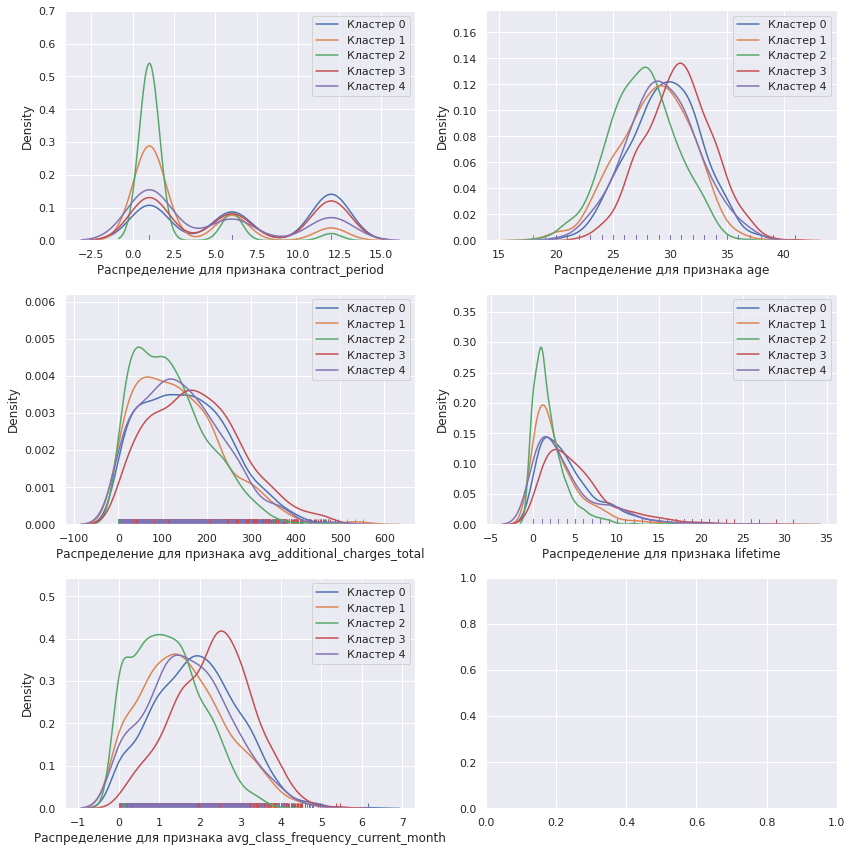

In [38]:
# построим гистограммы и распределения для числовых признаков
numeric_c.remove('month_to_end_contract')
numeric_c.remove('avg_class_frequency_total')
f, axes = plt.subplots(3, 2, figsize=(12, 12))
for ax, col in zip(axes.flat, numeric_c):
    sns.distplot(clients.query('cluster==0')[col], bins=15,ax=ax, hist=False, rug=True, kde_kws={'label':'Кластер 0'})
    sns.distplot(clients.query('cluster==1')[col], bins=15,ax=ax, hist=False, rug=True, kde_kws={'label':'Кластер 1'})
    sns.distplot(clients.query('cluster==2')[col], bins=15,ax=ax, hist=False, rug=True, kde_kws={'label':'Кластер 2'})
    sns.distplot(clients.query('cluster==3')[col], bins=15,ax=ax, hist=False, rug=True, kde_kws={'label':'Кластер 3'})
    sns.distplot(clients.query('cluster==4')[col], bins=15,ax=ax, hist=False, rug=True, kde_kws={'label':'Кластер 4'})
    ax.set(xlabel='Распределение для признака ' + col)
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

Учитывая, что клиенты 2 кластера наиболее склонны к оттоку, а 3 кластера - наоборот, сосредоточим внимание на них. 

- Исходя из данных на графике `contract_period` видно, что 2 кластер в основном состоит из клиентов, которые берут абонемент на один месяц и в следующем месяце перестают ходить - уходят в отток.

- Как видно по графику `age` 2 кластер в основном состоит из молодых клиентов, а 3 кластер - из людей, старше основной массы.

- Что касается дополнительных затрат - более надежные кластеры имеют более широкий график.

- Самый активный 3 кластер, в среднем 2.3 посещения в неделю. Минимальная активность наблюдается у 2 кластера, в среднем 1.2 занятие в неделю. Чем клиент активнее в течение недели посещяет зал, тем меньше вероятность его оттока

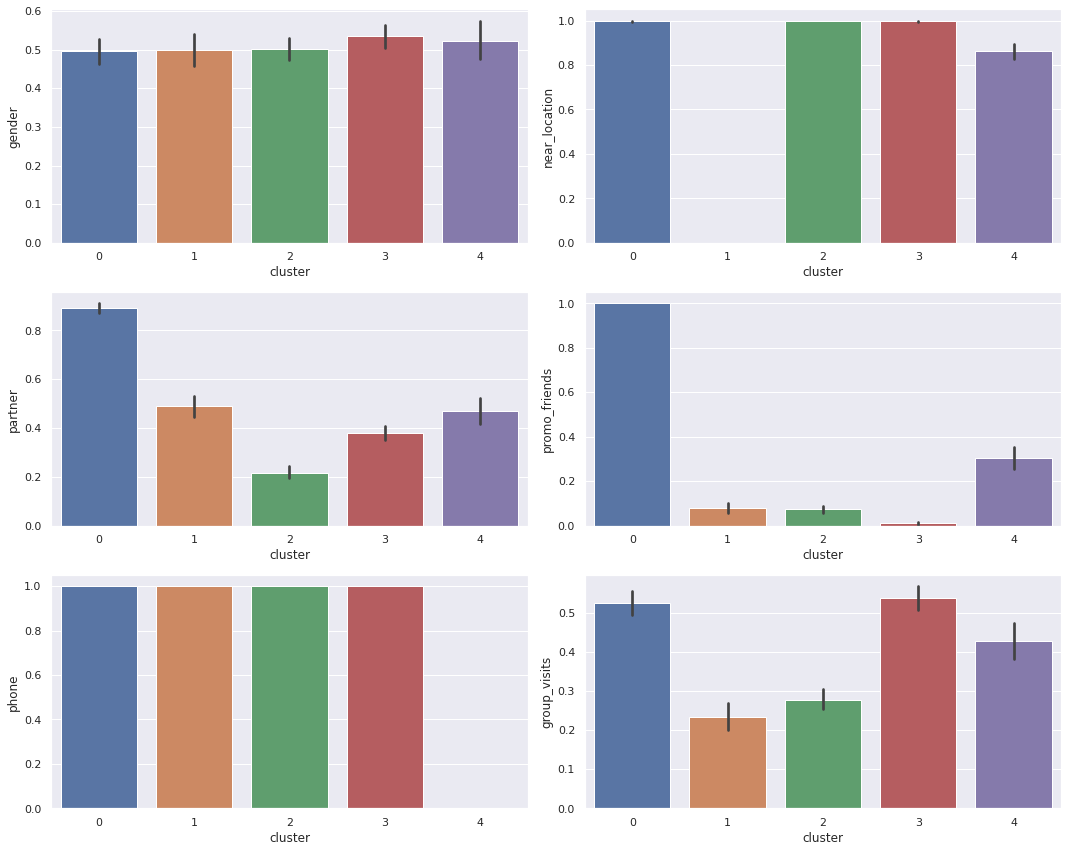

In [39]:
plt.figure(figsize=(15,12))
for i in range(len(clients[categ_c].columns)):
    plt.subplot(3,2,i+1)
    sns.barplot(x=clients['cluster'], y=clients[categ_c].iloc[:,i])
plt.tight_layout()
plt.show()

- Все кластеры распределены по полу равномерно.
- Только один кластер с клиентами, которые не живут рядом с клубом.
- Большинство клиентов 0 кластера пришли по приглашению партнеров или друзей.
- Только один кластер с клиентами, у которых не указан контактный телефон.
- Наиболее надежные клиенты ходят на групповые занятия.
- Клиенты из 2 кластера в среднем ходят в клуб два месяца, а затем прекращают посещения.

## Выводы и рекомендации

**Выводы**

- В ходе исследования мы определели наиболее эффективную модель -  логистической регрессии со стандартизацией - которая поможет успешно сделать прогноз вероятности оттока для каждого клиента.
- Также мы определили группу людей, наиболее склонных к оттоку. Ее описание: молодые люди (около 27 лет), оформившие абонемент на один месяц, посещающие зал примерно один раз в неделю, неохотно расстающиеся с деньгами на дополнительные услуги центра.
  А также наиболее надежных клиентов: людей средних лет (около 30 лет), живущих неподалеку, посеяющих зал не менее двух раз в неделю, участвующих в групповых занятиях, имеющих длительные абонементы.
- Лучше других признаков о вероятном оттоке клиента нам могут сказать продолжительность действия абонемента, возраст, количество посещений в неделю и период сотрудничества с нашим клубом.

**Рекомендации**
- Чтобы не допустить оттока, необходимо удерживать наиболее преданных клиентов, с которыми уже налажено продолжительное сотрудничество: поощрять их за покупку абонементов на 12 месяцев.
- Для снижения оттока следует предложить клиентам, в частности молодым людям, систему поощрений за покупку абонемента на 6 месяцев и более, за частое посещение клуба или групповых занятий.
- Для новых клиентов рассмотреть введение льготных цен на продление первого абонемента. 